In [1]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [23]:
import numpy as np
import itertools
import pandas as pd
from data_pipeline.processing import ClusterInput

def class_method_validation(Class, method : str):
    if not isinstance(method, str):
        raise TypeError("Please input the method as a string.")
    elif method not in dir(Class):
        raise AttributeError(f"Error: `{method}` is not a method of {Class}.")

def multi_run(Class, data_map, params_map, method_str : str):
    if data_map.keys() != params_map.keys():
        raise ValueError("The maps `data_map` and `param_map` must have the same keys.")

    class_method_validation(Class, method_str)
    
    dict_keys = data_map.keys()

    instances = {
        data_key : Class(**params_map[data_key])
        for data_key in dict_keys
    }

    for (data_key, data) in data_map.items():
        getattr(instances[data_key], method_str)(data)

    return instances

In [20]:
from sklearn.cluster import KMeans

In [12]:
df = pd.read_pickle('./data/dataframes/adj_closing_prices/SP_500_2021-11-30_2023-11-30_1mo.pkl')

In [34]:
original_feat_names = list(df.columns)

In [14]:
feat_to_label_map = DataBank().ticker_to_sector_map()
feat_to_label_map

{'MMM': 'Industrials',
 'AOS': 'Industrials',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Information Technology',
 'ADM': 'Consumer Staples',
 'ADBE': 'Information Technology',
 'ADP': 'Industrials',
 'AES': 'Utilities',
 'AFL': 'Financials',
 'A': 'Health Care',
 'ABNB': 'Consumer Discretionary',
 'APD': 'Materials',
 'AKAM': 'Information Technology',
 'ALK': 'Industrials',
 'ALB': 'Materials',
 'ARE': 'Real Estate',
 'ALGN': 'Health Care',
 'ALLE': 'Industrials',
 'LNT': 'Utilities',
 'ALL': 'Financials',
 'GOOGL': 'Communication Services',
 'GOOG': 'Communication Services',
 'MO': 'Consumer Staples',
 'AMZN': 'Consumer Discretionary',
 'AMCR': 'Materials',
 'AMD': 'Information Technology',
 'AEE': 'Utilities',
 'AAL': 'Industrials',
 'AEP': 'Utilities',
 'AXP': 'Financials',
 'AIG': 'Financials',
 'AMT': 'Real Estate',
 'AWK': 'Utilities',
 'AMP': 'Financials',
 'AME': 'Industrials',
 'AMGN': 'Health Care',
 'APH': 'Information Technology',
 'ADI': 'Information Technolo

In [15]:
feat_to_label_map = {ticker : feat_to_label_map[ticker] for ticker in original_feat_names}
feat_to_label_map

{'A': 'Health Care',
 'AAL': 'Industrials',
 'AAPL': 'Information Technology',
 'ABBV': 'Health Care',
 'ABNB': 'Consumer Discretionary',
 'ABT': 'Health Care',
 'ACGL': 'Financials',
 'ACN': 'Information Technology',
 'ADBE': 'Information Technology',
 'ADI': 'Information Technology',
 'ADM': 'Consumer Staples',
 'ADP': 'Industrials',
 'ADSK': 'Information Technology',
 'AEE': 'Utilities',
 'AEP': 'Utilities',
 'AES': 'Utilities',
 'AFL': 'Financials',
 'AIG': 'Financials',
 'AIZ': 'Financials',
 'AJG': 'Financials',
 'AKAM': 'Information Technology',
 'ALB': 'Materials',
 'ALGN': 'Health Care',
 'ALK': 'Industrials',
 'ALL': 'Financials',
 'ALLE': 'Industrials',
 'AMAT': 'Information Technology',
 'AMCR': 'Materials',
 'AMD': 'Information Technology',
 'AME': 'Industrials',
 'AMGN': 'Health Care',
 'AMP': 'Financials',
 'AMT': 'Real Estate',
 'AMZN': 'Consumer Discretionary',
 'ANET': 'Information Technology',
 'ANSS': 'Information Technology',
 'AON': 'Financials',
 'AOS': 'Industri

In [16]:
original_input = ClusterInput(df).df

In [17]:
labels_unique = list(set(feat_to_label_map.values()))

In [24]:
data_map = {
        label : ClusterInput(
            df[[col for col in df.columns if feat_to_label_map[col] == label]]
            ).df 
        for label in labels_unique
        }

d:\Desktop (D)\Erdos Intitute\Project\SP500-clustering\data_pipeline\processing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis = 1, inplace = True)
d:\Desktop (D)\Erdos Intitute\Project\SP500-clustering\data_pipeline\processing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis = 1, inplace = True)
d:\Desktop (D)\Erdos Intitute\Project\SP500-clustering\data_pipeline\processing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

d:\Desktop (D)\Erdos Intitute\Project\SP500-clustering\data_pipeline\processing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis = 1, inplace = True)
d:\Desktop (D)\Erdos Intitute\Project\SP500-clustering\data_pipeline\processing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis = 1, inplace = True)
d:\Desktop (D)\Erdos Intitute\Project\SP500-clustering\data_pipeline\processing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [25]:
runs = multi_run(Class = KMeans, data_map = data_map, params_map = {k : {} for k in data_map.keys()}, method_str = 'fit')

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

In [26]:
df.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:00:00,157.521179,17.959999,175.564056,125.262184,166.490005,135.702591,44.450001,402.574585,567.059998,169.428894,...,84.377617,63.784122,56.912109,54.270115,116.860123,133.725143,121.390121,595.200012,58.536816,240.062775
2022-01-01 00:00:00,137.462296,16.469999,172.805557,126.640640,153.970001,122.897903,46.320000,343.365845,534.299988,158.659973,...,84.784424,66.081680,70.649506,52.065777,102.340309,120.541374,117.771477,509.119995,62.855721,196.542023
2022-02-01 00:00:00,128.791168,17.250000,163.254700,138.124588,151.490005,116.712952,47.110001,307.686554,467.679993,155.099121,...,85.846085,63.871365,72.937531,52.767521,86.680359,118.047150,121.763573,413.339996,65.700996,190.807755
2022-03-01 00:00:00,130.737457,18.250000,172.857437,151.528595,171.759995,114.526161,48.419998,328.337250,455.619995,160.610779,...,79.118896,68.462746,77.667572,47.972248,83.359230,114.676819,126.116577,413.700012,61.073463,185.822037
2022-04-01 00:00:00,117.834641,18.770000,156.067657,137.292709,153.210007,109.823578,45.669998,292.439514,395.950012,150.109558,...,69.931030,69.982063,80.169044,39.074932,78.705353,113.206245,119.294807,369.660004,52.642788,174.648468


In [28]:
new_feat_to_label

{'A': 'Health Care 2',
 'ABBV': 'Health Care 3',
 'ABT': 'Health Care 5',
 'ALGN': 'Health Care 4',
 'AMGN': 'Health Care 3',
 'BAX': 'Health Care 5',
 'BDX': 'Health Care 3',
 'BIIB': 'Health Care 3',
 'BIO': 'Health Care 1',
 'BMY': 'Health Care 3',
 'BSX': 'Health Care 5',
 'CAH': 'Health Care 0',
 'CI': 'Health Care 0',
 'CNC': 'Health Care 0',
 'COO': 'Health Care 5',
 'COR': 'Health Care 0',
 'CRL': 'Health Care 2',
 'CTLT': 'Health Care 7',
 'CVS': 'Health Care 0',
 'DGX': 'Health Care 3',
 'DHR': 'Health Care 2',
 'DVA': 'Health Care 1',
 'DXCM': 'Health Care 6',
 'ELV': 'Health Care 0',
 'EW': 'Health Care 1',
 'GILD': 'Health Care 3',
 'HCA': 'Health Care 5',
 'HOLX': 'Health Care 5',
 'HSIC': 'Health Care 5',
 'HUM': 'Health Care 0',
 'IDXX': 'Health Care 2',
 'ILMN': 'Health Care 2',
 'INCY': 'Health Care 3',
 'IQV': 'Health Care 2',
 'ISRG': 'Health Care 2',
 'JNJ': 'Health Care 3',
 'LH': 'Health Care 5',
 'LLY': 'Health Care 3',
 'MCK': 'Health Care 0',
 'MDT': 'Health C

In [35]:
new_feat_to_label = {
    ticker : new_feat_to_label[ticker] for ticker in original_feat_names
}

In [38]:
list(new_feat_to_label.values())

['Health Care 2',
 'Industrials 3',
 'Information Technology 5',
 'Health Care 3',
 'Consumer Discretionary 4',
 'Health Care 5',
 'Financials 2',
 'Information Technology 2',
 'Information Technology 5',
 'Information Technology 0',
 'Consumer Staples 2',
 'Industrials 7',
 'Information Technology 5',
 'Utilities 0',
 'Utilities 0',
 'Utilities 6',
 'Financials 2',
 'Financials 2',
 'Financials 5',
 'Financials 5',
 'Information Technology 2',
 'Materials 0',
 'Health Care 4',
 'Industrials 3',
 'Financials 2',
 'Industrials 0',
 'Information Technology 0',
 'Materials 3',
 'Information Technology 4',
 'Industrials 0',
 'Health Care 3',
 'Financials 3',
 'Real Estate 4',
 'Consumer Discretionary 5',
 'Information Technology 2',
 'Information Technology 0',
 'Financials 5',
 'Industrials 5',
 'Energy 0',
 'Materials 3',
 'Information Technology 5',
 'Consumer Discretionary 1',
 'Real Estate 0',
 'Utilities 5',
 'Real Estate 3',
 'Information Technology 2',
 'Materials 6',
 'Utilities 1

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from typing import Union
from dataclasses import dataclass
import numpy as np

@dataclass
class Cluster:
    label: str
    cluster: Union[np.ndarray, list[int, str]]

class MultiKMeans:
    def __init__(self, multi_n_clusters = [1]):
        self.multi_n_clusters = multi_n_clusters
    
    def multi_fit(self, pre_clusters = list[Cluster]):

        if len(pre_clusters) != len(self.multi_n_clusters):
            raise ValueError("The arrays `pre_clusters` and `multi_n_clusters` must be of the same length.")
        
        if any(type(pre_cluster) != Cluster for pre_cluster in pre_clusters):
            raise ValueError("Your pre-clusters must be Cluster objects.")
        
        instances = {}

        for (i, (pre_cluster, n_cluster)) in enumerate(zip(pre_clusters, self.multi_n_clusters)):
            KM_instance = KMeans(n_clusters=n_cluster)
            KM_instance.fit(pre_cluster.cluster)
            instances.update({i : KM_instance})
        
        return instances
    
    @staticmethod
    def merge_clusters(old_clusters : list[Cluster], new_labels_list):

        old_labels = [old_cluster.label for old_cluster in old_clusters]
        
        return [
            f'{old_label}_{label}' for (old_label, new_labels) in zip(old_labels, new_labels_list) for label in new_labels 
        ]

In [ ]:
km_mult = MultiKMeans([2, 12])

pre_clusters = [
    Cluster('c1', df[:5].T),
    Cluster('c2', df[6:].T)
]

km_mult_runs = km_mult.multi_fit(pre_clusters)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

In [ ]:
new_labels = [run.labels_ for run in km_mult_runs.values()]

In [ ]:
new_labels

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
params = [{
    'n_clusters' : 2,
    'init' : 'k-means++'
},
{}]

data = [
    df.T[:50],
    df.T[56:]
]

In [197]:
df.T.index.values

array(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG',
       'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT',
       'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS',
       'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL',
       'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BIO', 'BK',
       'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BX',
       'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE',
       'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG',
       'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA',
       'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP',
       'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP',
       'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 

In [ ]:
runs = multi_run(KMeans, 'fit', data, params)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

In [ ]:
runs[0].labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import calinski_harabasz_score as ch_score

In [ ]:
DF = df[:10]

labels_list = []

k_range = list(range(2, len(DF)-1))

for k in k_range:
    KM = KMeans(n_clusters=k)

    labels_list.append(KM.fit(DF).labels_)

scores = [ch_score(DF, labels) for labels in labels_list]

optimal_index = scores.index(max(scores))

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

In [ ]:
ch_score(DF, labels_list[optimal_index])

11.630878258516844

In [ ]:
[ch_score(DF, labels) for labels in labels_list]

[11.291329851777157,
 11.630878258516844,
 10.54448866155086,
 9.560825862821913,
 8.76595699879816,
 9.148790137815196,
 9.184828950917103]

In [ ]:
labels_list[optimal_index]

array([2, 2, 2, 2, 2, 0, 0, 0, 1, 1])

In [ ]:
from model_selection.utils import grid_search

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as ch_score

In [ ]:
import pandas as pd

In [187]:
df.T

Date,2023-11-14,2023-11-15,2023-11-16,2023-11-17,2023-11-20,2023-11-21,2023-11-22,2023-11-24,2023-11-27,2023-11-28
A,111.610001,113.599998,114.190002,113.150002,113.980003,123.919998,123.989998,126.620003,125.010002,124.709999
AAL,12.250000,12.420000,12.190000,12.290000,12.400000,12.130000,12.310000,12.310000,12.180000,12.170000
AAPL,187.440002,188.009995,189.710007,189.690002,191.449997,190.639999,191.309998,189.970001,189.789993,190.399994
ABBV,138.059998,137.600006,138.279999,138.300003,138.309998,138.729996,138.470001,138.669998,139.089996,138.080002
ABNB,126.680000,128.350006,126.279999,127.150002,129.699997,126.820000,129.039993,128.369995,129.000000,127.559998
...,...,...,...,...,...,...,...,...,...,...
YUM,126.929611,126.023903,127.228203,127.059006,127.516830,127.636276,128.332977,127.904991,127.690002,126.389999
ZBH,108.070000,110.500000,111.550003,111.669998,112.500000,112.900002,113.830002,113.430000,113.839996,113.089996
ZBRA,215.660004,216.960007,215.479996,218.020004,220.539993,222.410004,225.860001,228.919998,231.500000,233.889999
ZION,35.369999,36.080002,35.709999,36.070000,35.779999,34.310001,34.410000,34.349998,34.400002,34.549999


In [186]:
ch_score(df.T, labels)

0.4467147590897931

In [ ]:
df = pd.read_pickle("./data/dataframes/closing_prices/SP500_2023-11-14_2023-11-29.pkl")

In [ ]:
param_grid = {
    'n_clusters': range(2, 10),
    'init': ['k-means++', 'random'],
    'n_init': [10, 15, 20]
}

In [ ]:
grid_search(KMeans, 'fit', df.T, ch_score, param_grid=param_grid)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

{'n_clusters': 9, 'init': 'k-means++', 'n_init': 10}

In [ ]:
grid_search(KMeans, 'fit', cluster_input, ch_score, param_grid=param_grid)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

{'n_clusters': 2, 'init': 'random', 'n_init': 15}

In [ ]:
from data_pipeline.processing import ClusterInput

In [ ]:
cluster_input = ClusterInput(df).df

In [ ]:
ch_score(df.T, KMeans(**{'n_clusters': 9, 'init': 'k-means++', 'n_init': 10}).fit(df.T).labels_)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


6660.356304413925

In [ ]:
from cluster.benchmark import SectorCluster

In [ ]:
ch_score(df.T, SectorCluster().fit(list(df.columns)).labels_)

0.4467147590897931

In [ ]:
from sklearn.metrics import davies_bouldin_score as db_score

In [ ]:
db_score(df.T, SectorCluster().fit(list(df.columns)).labels_)

30.231891003369427

In [ ]:
db_score(df.T, KMeans(**{'n_clusters': 9, 'init': 'k-means++', 'n_init': 10}).fit(df.T).labels_)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.41583996400520834

In [ ]:
from numpy import arctan, pi

In [ ]:
arctan(0.41583996400520834) / (pi / 2)

0.25088326024070684

In [ ]:
arctan(30.231891003369427) / (pi / 2)

0.9789497870720829

In [ ]:
df2 = pd.read_pickle("./data/stocks/closing_prices.pkl")

In [ ]:
import pickle
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)

In [ ]:
cluster_input2 = ClusterInput(df2).df

In [ ]:
grid_search(KMeans, 'fit', cluster_input2, ch_score, param_grid)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

{'n_clusters': 2, 'init': 'random', 'n_init': 20}

In [ ]:
ch_score(cluster_input, KMeans(**{'n_clusters': 2, 'init': 'random', 'n_init': 15}).fit(cluster_input).labels_)

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


113.17776047213009

In [ ]:
ch_score(cluster_input, SectorCluster().fit(list(df.columns)).labels_)

1.0888310209370022

In [ ]:
labels = SectorCluster().fit(list(df.columns)).labels_

In [ ]:
df = pd.read_pickle('data\dataframes\closing_prices\SP500_2023-11-14_2023-11-29.pkl')

In [ ]:
import yfinance

In [ ]:
df.columns

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WYNN', 'XEL', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION',
       'ZTS'],
      dtype='object', length=501)

In [ ]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

tickers = table['Symbol']

Map = table[table['Symbol'].isin(tickers)][
            ['Symbol', 'GICS Sector']
            ].set_index('Symbol').to_dict()['GICS Sector']

'Information Technology'

In [ ]:
Map['AAPL']

'Information Technology'

In [ ]:
yfinance.download(['XEL', 'MMM', 'AAPL', 'WYNN'], '2023-11-14')['Adj Close']

[                       0%%                      ]

[*********************100%%**********************]  4 of 4 completed


,AAPL,MMM,WYNN,XEL
Date,,,,
2023-11-14,187.440002,93.498665,86.866920,60.299999
2023-11-15,188.009995,95.320000,87.205933,60.090000
2023-11-16,189.710007,95.709999,85.809998,60.700001
2023-11-17,189.690002,95.339996,86.870003,60.560001
2023-11-20,191.449997,94.980003,87.169998,60.060001
2023-11-21,190.639999,93.989998,86.860001,60.020000
2023-11-22,191.309998,95.370003,87.529999,60.430000
2023-11-24,189.970001,95.949997,88.309998,60.520000
2023-11-27,189.789993,97.070000,87.059998,60.450001


In [ ]:
feat_to_label_map = {col : ind for (col, ind) in zip(df.columns, labels)}

In [ ]:
labels_unique = list(set(labels))

In [ ]:
labels_unique

['Financials',
 'Consumer Discretionary',
 'Energy',
 'Consumer Staples',
 'Information Technology',
 'Materials',
 'Industrials',
 'Utilities',
 'Real Estate',
 'Health Care',
 'Communication Services']

In [ ]:
df[[col for col in df.columns if feat_to_label_map[col] == labels_unique[0]]]

,ADI,AKAM,AMGN,AMP,ANET,APH,AVGO,AWK,AXON,BEN,...,SYK,TDG,TER,TXN,TYL,UHS,WAB,WM,WYNN,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-14,177.580002,112.120003,267.913483,342.440002,215.199997,88.709999,972.960022,129.740005,221.580002,23.940001,...,283.029999,961.392822,90.542130,149.929993,419.549988,132.610001,115.540001,172.139999,86.866920,35.369999
2023-11-15,180.779999,112.059998,270.899994,343.470001,213.740005,89.040001,975.400024,130.449997,221.080002,24.559999,...,283.640015,958.904297,91.261276,151.869995,417.670013,132.899994,114.879997,171.169998,87.205933,36.080002
2023-11-16,179.839996,111.370003,269.000000,344.200012,213.300003,89.550003,959.549988,130.990005,222.759995,24.549999,...,291.549988,951.950012,90.632019,151.889999,417.679993,134.449997,114.750000,171.440002,85.809998,35.709999
2023-11-17,183.050003,112.370003,265.390015,347.829987,214.630005,89.699997,977.729980,132.100006,223.479996,24.270000,...,288.380005,957.630005,91.980415,154.619995,411.339996,135.960007,115.510002,170.550003,86.870003,36.070000
2023-11-20,183.820007,112.470001,265.350006,349.480011,215.339996,89.550003,995.710022,130.669998,226.220001,24.200001,...,289.290009,964.359985,92.969238,155.539993,411.989990,135.940002,115.620003,171.179993,87.169998,35.779999
2023-11-21,181.250000,113.129997,262.820007,347.959991,215.320007,89.669998,981.200012,130.830002,228.419998,23.680000,...,293.660004,971.030029,91.650810,153.429993,411.040009,136.039993,116.050003,171.690002,86.860001,34.310001
2023-11-22,182.669998,113.570000,264.589996,350.519989,217.690002,90.089996,972.000000,130.470001,226.869995,23.879999,...,294.049988,970.200012,92.330002,153.929993,411.869995,138.380005,116.309998,171.770004,87.529999,34.410000
2023-11-24,183.050003,113.650002,265.459991,351.420013,218.389999,90.360001,978.869995,132.059998,228.419998,23.820000,...,293.640015,970.729980,92.489998,153.589996,410.119995,138.720001,117.059998,172.009995,88.309998,34.349998
2023-11-27,183.770004,113.750000,264.269989,349.470001,218.669998,90.120003,950.239990,130.750000,228.160004,23.709999,...,293.959991,976.580017,91.930000,152.600006,411.269989,137.229996,116.730003,171.479996,87.059998,34.400002


In [121]:
feat_to_label_map = SectorCluster().ticker_to_sector_map(list(df.columns))
feat_to_label_map

{'MMM': 'Industrials',
 'AOS': 'Industrials',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Information Technology',
 'ADM': 'Consumer Staples',
 'ADBE': 'Information Technology',
 'ADP': 'Industrials',
 'AES': 'Utilities',
 'AFL': 'Financials',
 'A': 'Health Care',
 'ABNB': 'Consumer Discretionary',
 'APD': 'Materials',
 'AKAM': 'Information Technology',
 'ALK': 'Industrials',
 'ALB': 'Materials',
 'ARE': 'Real Estate',
 'ALGN': 'Health Care',
 'ALLE': 'Industrials',
 'LNT': 'Utilities',
 'ALL': 'Financials',
 'GOOGL': 'Communication Services',
 'GOOG': 'Communication Services',
 'MO': 'Consumer Staples',
 'AMZN': 'Consumer Discretionary',
 'AMCR': 'Materials',
 'AMD': 'Information Technology',
 'AEE': 'Utilities',
 'AAL': 'Industrials',
 'AEP': 'Utilities',
 'AXP': 'Financials',
 'AIG': 'Financials',
 'AMT': 'Real Estate',
 'AWK': 'Utilities',
 'AMP': 'Financials',
 'AME': 'Industrials',
 'AMGN': 'Health Care',
 'APH': 'Information Technology',
 'ADI': 'Information Technolo

In [152]:
feat_to_label_map.keys() == feat_to_label_map.keys()

True

In [123]:
labels_unique = list(set(feat_to_label_map.values()))
labels_unique

['Communication Services',
 'Utilities',
 'Energy',
 'Health Care',
 'Industrials',
 'Consumer Discretionary',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Financials',
 'Consumer Staples']

In [168]:
df.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-14,111.610001,12.25,187.440002,138.059998,126.680000,97.080002,85.500000,320.489990,604.330017,177.580002,...,86.866920,60.299999,104.290001,28.940001,100.869865,126.929611,108.070000,215.660004,35.369999,172.649994
2023-11-15,113.599998,12.42,188.009995,137.600006,128.350006,98.000000,82.660004,325.500000,595.309998,180.779999,...,87.205933,60.090000,103.660004,29.320000,99.913002,126.023903,110.500000,216.960007,36.080002,174.619995
2023-11-16,114.190002,12.19,189.710007,138.279999,126.279999,100.260002,83.709999,327.320007,602.059998,179.839996,...,85.809998,60.700001,102.459999,29.600000,100.929672,127.228203,111.550003,215.479996,35.709999,176.539993
2023-11-17,113.150002,12.29,189.690002,138.300003,127.150002,99.550003,83.599998,327.829987,602.659973,183.050003,...,86.870003,60.560001,104.959999,29.690001,100.830002,127.059006,111.669998,218.020004,36.070000,174.800003
2023-11-20,113.980003,12.40,191.449997,138.309998,129.699997,101.199997,84.459999,330.899994,612.700012,183.820007,...,87.169998,60.060001,104.500000,29.940001,100.209999,127.516830,112.500000,220.539993,35.779999,176.059998


In [180]:
from sklearn.metrics import calinski_harabasz_score as ch_score 

In [183]:
ch_score(list(df.columns), labels)

ValueError: Expected 2D array, got 1D array instead:
array=['A' 'AAL' 'AAPL' 'ABBV' 'ABNB' 'ABT' 'ACGL' 'ACN' 'ADBE' 'ADI' 'ADM'
 'ADP' 'ADSK' 'AEE' 'AEP' 'AES' 'AFL' 'AIG' 'AIZ' 'AJG' 'AKAM' 'ALB'
 'ALGN' 'ALK' 'ALL' 'ALLE' 'AMAT' 'AMCR' 'AMD' 'AME' 'AMGN' 'AMP' 'AMT'
 'AMZN' 'ANET' 'ANSS' 'AON' 'AOS' 'APA' 'APD' 'APH' 'APTV' 'ARE' 'ATO'
 'AVB' 'AVGO' 'AVY' 'AWK' 'AXON' 'AXP' 'AZO' 'BA' 'BAC' 'BALL' 'BAX'
 'BBWI' 'BBY' 'BDX' 'BEN' 'BG' 'BIIB' 'BIO' 'BK' 'BKNG' 'BKR' 'BLK' 'BMY'
 'BR' 'BRO' 'BSX' 'BWA' 'BX' 'BXP' 'C' 'CAG' 'CAH' 'CARR' 'CAT' 'CB'
 'CBOE' 'CBRE' 'CCI' 'CCL' 'CDAY' 'CDNS' 'CDW' 'CE' 'CEG' 'CF' 'CFG' 'CHD'
 'CHRW' 'CHTR' 'CI' 'CINF' 'CL' 'CLX' 'CMA' 'CMCSA' 'CME' 'CMG' 'CMI'
 'CMS' 'CNC' 'CNP' 'COF' 'COO' 'COP' 'COR' 'COST' 'CPB' 'CPRT' 'CPT' 'CRL'
 'CRM' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTLT' 'CTRA' 'CTSH' 'CTVA' 'CVS' 'CVX'
 'CZR' 'D' 'DAL' 'DD' 'DE' 'DFS' 'DG' 'DGX' 'DHI' 'DHR' 'DIS' 'DLR' 'DLTR'
 'DOV' 'DOW' 'DPZ' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN' 'DXCM' 'EA' 'EBAY' 'ECL'
 'ED' 'EFX' 'EG' 'EIX' 'EL' 'ELV' 'EMN' 'EMR' 'ENPH' 'EOG' 'EPAM' 'EQIX'
 'EQR' 'EQT' 'ES' 'ESS' 'ETN' 'ETR' 'ETSY' 'EVRG' 'EW' 'EXC' 'EXPD' 'EXPE'
 'EXR' 'F' 'FANG' 'FAST' 'FCX' 'FDS' 'FDX' 'FE' 'FFIV' 'FI' 'FICO' 'FIS'
 'FITB' 'FLT' 'FMC' 'FOX' 'FOXA' 'FRT' 'FSLR' 'FTNT' 'FTV' 'GD' 'GE'
 'GEHC' 'GEN' 'GILD' 'GIS' 'GL' 'GLW' 'GM' 'GNRC' 'GOOG' 'GOOGL' 'GPC'
 'GPN' 'GRMN' 'GS' 'GWW' 'HAL' 'HAS' 'HBAN' 'HCA' 'HD' 'HES' 'HIG' 'HII'
 'HLT' 'HOLX' 'HON' 'HPE' 'HPQ' 'HRL' 'HSIC' 'HST' 'HSY' 'HUBB' 'HUM'
 'HWM' 'IBM' 'ICE' 'IDXX' 'IEX' 'IFF' 'ILMN' 'INCY' 'INTC' 'INTU' 'INVH'
 'IP' 'IPG' 'IQV' 'IR' 'IRM' 'ISRG' 'IT' 'ITW' 'IVZ' 'J' 'JBHT' 'JCI'
 'JKHY' 'JNJ' 'JNPR' 'JPM' 'K' 'KDP' 'KEY' 'KEYS' 'KHC' 'KIM' 'KLAC' 'KMB'
 'KMI' 'KMX' 'KO' 'KR' 'KVUE' 'L' 'LDOS' 'LEN' 'LH' 'LHX' 'LIN' 'LKQ'
 'LLY' 'LMT' 'LNT' 'LOW' 'LRCX' 'LULU' 'LUV' 'LVS' 'LW' 'LYB' 'LYV' 'MA'
 'MAA' 'MAR' 'MAS' 'MCD' 'MCHP' 'MCK' 'MCO' 'MDLZ' 'MDT' 'MET' 'META'
 'MGM' 'MHK' 'MKC' 'MKTX' 'MLM' 'MMC' 'MMM' 'MNST' 'MO' 'MOH' 'MOS' 'MPC'
 'MPWR' 'MRK' 'MRNA' 'MRO' 'MS' 'MSCI' 'MSFT' 'MSI' 'MTB' 'MTCH' 'MTD'
 'MU' 'NCLH' 'NDAQ' 'NDSN' 'NEE' 'NEM' 'NFLX' 'NI' 'NKE' 'NOC' 'NOW' 'NRG'
 'NSC' 'NTAP' 'NTRS' 'NUE' 'NVDA' 'NVR' 'NWS' 'NWSA' 'NXPI' 'O' 'ODFL'
 'OKE' 'OMC' 'ON' 'ORCL' 'ORLY' 'OTIS' 'OXY' 'PANW' 'PARA' 'PAYC' 'PAYX'
 'PCAR' 'PCG' 'PEAK' 'PEG' 'PEP' 'PFE' 'PFG' 'PG' 'PGR' 'PH' 'PHM' 'PKG'
 'PLD' 'PM' 'PNC' 'PNR' 'PNW' 'PODD' 'POOL' 'PPG' 'PPL' 'PRU' 'PSA' 'PSX'
 'PTC' 'PWR' 'PXD' 'PYPL' 'QCOM' 'QRVO' 'RCL' 'REG' 'REGN' 'RF' 'RHI'
 'RJF' 'RL' 'RMD' 'ROK' 'ROL' 'ROP' 'ROST' 'RSG' 'RTX' 'RVTY' 'SBAC'
 'SBUX' 'SCHW' 'SEDG' 'SEE' 'SHW' 'SJM' 'SLB' 'SNA' 'SNPS' 'SO' 'SPG'
 'SPGI' 'SRE' 'STE' 'STLD' 'STT' 'STX' 'STZ' 'SWK' 'SWKS' 'SYF' 'SYK'
 'SYY' 'T' 'TAP' 'TDG' 'TDY' 'TECH' 'TEL' 'TER' 'TFC' 'TFX' 'TGT' 'TJX'
 'TMO' 'TMUS' 'TPR' 'TRGP' 'TRMB' 'TROW' 'TRV' 'TSCO' 'TSLA' 'TSN' 'TT'
 'TTWO' 'TXN' 'TXT' 'TYL' 'UAL' 'UDR' 'UHS' 'ULTA' 'UNH' 'UNP' 'UPS' 'URI'
 'USB' 'V' 'VFC' 'VICI' 'VLO' 'VLTO' 'VMC' 'VRSK' 'VRSN' 'VRTX' 'VTR'
 'VTRS' 'VZ' 'WAB' 'WAT' 'WBA' 'WBD' 'WDC' 'WEC' 'WELL' 'WFC' 'WHR' 'WM'
 'WMB' 'WMT' 'WRB' 'WRK' 'WST' 'WTW' 'WY' 'WYNN' 'XEL' 'XOM' 'XRAY' 'XYL'
 'YUM' 'ZBH' 'ZBRA' 'ZION' 'ZTS'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [149]:
dfs = {label : df[[col for col in df.columns if feat_to_label_map[col] == label]] for label in labels_unique}

In [150]:
dfs['Health Care']

,A,ABBV,ABT,ALGN,AMGN,BAX,BDX,BIIB,BIO,BMY,...,TMO,UHS,UNH,VRTX,VTRS,WAT,WST,XRAY,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-14,111.610001,138.059998,97.080002,202.720001,267.913483,34.349998,233.339996,225.259995,307.480011,50.520000,...,459.260010,132.610001,540.460022,369.950012,9.102047,258.670013,347.480011,28.940001,108.070000,172.649994
2023-11-15,113.599998,137.600006,98.000000,205.059998,270.899994,35.310001,233.759995,229.630005,306.890015,51.570000,...,470.540009,132.899994,538.409973,349.339996,9.240255,266.940002,345.980011,29.320000,110.500000,174.619995
2023-11-16,114.190002,138.279999,100.260002,203.119995,269.000000,35.450001,235.070007,229.460007,304.500000,50.840000,...,472.470001,134.449997,539.820007,343.000000,9.052687,266.200012,344.230011,29.600000,111.550003,176.539993
2023-11-17,113.150002,138.300003,99.550003,206.639999,265.390015,35.459999,233.270004,228.000000,299.359985,50.840000,...,466.420013,135.960007,536.289978,350.500000,9.329104,261.880005,342.750000,29.690001,111.669998,174.800003
2023-11-20,113.980003,138.309998,101.199997,215.240005,265.350006,35.619999,233.669998,230.110001,304.519989,48.900002,...,469.029999,135.940002,535.099976,356.839996,9.348848,260.929993,349.029999,29.940001,112.500000,176.059998
2023-11-21,123.919998,138.729996,101.910004,215.300003,262.820007,35.700001,236.160004,229.570007,306.179993,48.480000,...,482.390015,136.039993,539.590027,354.779999,9.260000,274.649994,352.489990,30.990000,112.900002,178.729996
2023-11-22,123.989998,138.470001,102.699997,217.289993,264.589996,35.869999,236.800003,231.250000,309.880005,49.419998,...,487.529999,138.380005,543.760010,353.230011,9.370000,276.329987,351.170013,31.360001,113.830002,179.350006
2023-11-24,126.620003,138.669998,102.870003,219.479996,265.459991,36.020000,238.889999,231.949997,311.190002,49.759998,...,490.779999,138.720001,547.099976,353.040009,9.430000,280.390015,353.260010,31.320000,113.430000,180.210007
2023-11-27,125.010002,139.089996,102.709999,216.750000,264.269989,36.419998,238.860001,228.789993,307.140015,49.020000,...,490.130005,137.229996,543.590027,350.190002,9.340000,277.000000,353.899994,31.480000,113.839996,178.789993


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_pickle('data\dataframes\closing_prices\SP500_2023-11-14_2023-11-29.pkl')

In [ ]:
from data_pipeline.processing import ClusterInput

In [ ]:
from cluster.benchmark import SectorCluster

In [ ]:
sector_benchmark = SectorCluster()

In [ ]:
labels = sector_benchmark.fit(df).labels_

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=3)
reduced_data = svd.fit_transform(ClusterInput(df).df)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoded_labels = LabelEncoder().fit_transform(labels)
encoded_labels

array([ 6,  6,  5,  5,  7,  2,  7,  6, 10,  4,  5,  1,  8,  7,  6,  8,  9,
        5,  6, 10,  4,  0,  0,  2,  1,  8,  7, 10,  6, 10,  4,  4,  9, 10,
        4,  6,  5,  7,  7,  7,  4,  3,  7,  7,  1,  4,  7,  4,  4,  0, 10,
        7,  1,  9,  8,  6,  3,  8,  4,  1,  5,  5,  4,  1,  5,  5,  5,  4,
        4,  4,  6,  1,  1,  9,  5,  5,  7,  6,  4,  2,  6,  7,  1,  9,  2,
        4,  5,  1,  1,  6,  5,  6,  4,  9,  7,  8,  5,  5, 10,  6,  8,  5,
        4,  0,  3,  1,  4,  2,  5,  4,  6,  7,  4,  4,  2,  4, 10,  2,  7,
        2,  0,  4,  2,  3, 10,  2, 10,  5,  6,  7,  8,  9,  2,  3,  9,  6,
        6,  5,  1,  5,  1,  5,  6,  6,  5,  3,  5,  3,  9,  4,  0,  2,  2,
       10,  1,  6,  8, 10, 10,  8,  8,  6,  1,  8, 10,  5,  0,  5,  5,  6,
        7, 10,  3,  7,  3,  6,  9,  9,  9,  2,  1,  4, 10, 10, 10,  1,  6,
        9,  3,  7,  4,  7,  6,  9,  6,  4,  7, 10,  4,  4,  4,  8,  1,  7,
        6,  0,  0,  4,  8,  1,  7,  5,  7,  6,  6,  6,  2,  1,  1,  5,  4,
        4,  4,  3,  4,  1

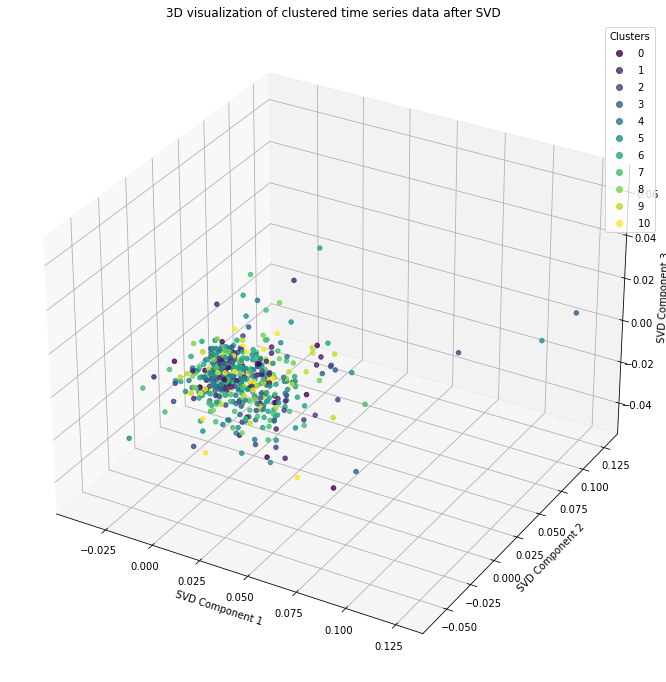

In [ ]:
x = reduced_data[:,0]
y = reduced_data[:,1]
z = reduced_data[:,2]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, c=encoded_labels, s = 20, alpha = 0.8, cmap='viridis', plotnonfinite = True)

ax.set_xlabel('SVD Component 1')
ax.set_ylabel('SVD Component 2')
ax.set_zlabel('SVD Component 3')
plt.title('3D visualization of clustered time series data after SVD')

plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
import numpy as np

In [ ]:
unique_labels = np.unique(labels)
unique_encoded = np.unique(encoded_labels)

In [ ]:
fig = go.Figure()

for ulabel, ucode in zip(unique_labels, unique_encoded):
    fig.add_trace(go.Scatter3d(
        x=reduced_data[encoded_labels == ucode, 0],
        y=reduced_data[encoded_labels == ucode, 1],
        z=reduced_data[encoded_labels == ucode, 2],
        mode='markers',
        name=ulabel,  # Assign the original label as the trace name
        marker=dict(
            size=5,
            opacity=0.8
        )
    ))

fig.update_layout(
    title='3D SVD Visualization with String Labels',
    scene=dict(
        xaxis_title='SVD Component 1',
        yaxis_title='SVD Component 2',
        zaxis_title='SVD Component 3'
    ),
    legend_title="Labels",
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

In [ ]:
pd.read_pickle(".data\dataframes\adj_closing_prices\SP_500_2021-11-30_2023-11-30_1mo.pkl")

In [ ]:
from sklearn.cluster import KMeans

In [74]:
from data_pipeline.processing import ROR, market_adjust, industry_adjust, l2_normalization, ClusterInput

In [68]:
clusters = list(SectorCluster().ticker_to_sector_map(list(df.columns)).values())
clusters 

['Industrials',
 'Industrials',
 'Health Care',
 'Health Care',
 'Information Technology',
 'Consumer Staples',
 'Information Technology',
 'Industrials',
 'Utilities',
 'Financials',
 'Health Care',
 'Consumer Discretionary',
 'Materials',
 'Information Technology',
 'Industrials',
 'Materials',
 'Real Estate',
 'Health Care',
 'Industrials',
 'Utilities',
 'Financials',
 'Communication Services',
 'Communication Services',
 'Consumer Staples',
 'Consumer Discretionary',
 'Materials',
 'Information Technology',
 'Utilities',
 'Industrials',
 'Utilities',
 'Financials',
 'Financials',
 'Real Estate',
 'Utilities',
 'Financials',
 'Industrials',
 'Health Care',
 'Information Technology',
 'Information Technology',
 'Information Technology',
 'Financials',
 'Energy',
 'Information Technology',
 'Information Technology',
 'Consumer Discretionary',
 'Financials',
 'Information Technology',
 'Financials',
 'Financials',
 'Communication Services',
 'Utilities',
 'Information Technology',
 'C

In [72]:
cluster_transform = lambda df : l2_normalization(
    industry_adjust(
        market_adjust(
            ROR(
                df[::2]
            )
        ), clusters=clusters
    )
)

In [75]:
cluster_input = ClusterInput(df, cluster_transform).df 
cluster_input

d:\Desktop (D)\Erdos Intitute\Project\SP500-clustering\data_pipeline\processing.py:204: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date,2023-11-16,2023-11-20,2023-11-22,2023-11-27
Ticker,,,,
A,0.221828,-0.098745,0.965185,0.097267
AAL,-0.428323,0.516557,-0.538977,-0.509129
AAPL,0.710948,0.049251,-0.266097,-0.649092
ABBV,-0.054264,-0.908612,-0.204988,0.359805
ABNB,-0.130948,0.936410,-0.282858,-0.161182
...,...,...,...,...
YUM,0.134875,-0.598693,0.628598,-0.477744
ZBH,0.931005,-0.098260,0.346125,-0.061425
ZBRA,-0.082841,0.425470,0.598356,0.673857


In [76]:
k = 10
km = KMeans(n_clusters=k)
km_labels = km.fit(cluster_input).labels_

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [77]:
km_labels

array([9, 0, 1, 3, 5, 1, 7, 1, 5, 5, 2, 2, 0, 3, 9, 0, 3, 9, 7, 9, 7, 0,
       5, 5, 8, 0, 3, 6, 5, 2, 3, 5, 8, 4, 7, 0, 3, 3, 4, 8, 8, 5, 7, 3,
       7, 0, 8, 8, 5, 5, 2, 5, 0, 1, 1, 3, 6, 9, 8, 2, 8, 2, 5, 4, 4, 1,
       3, 9, 9, 9, 5, 5, 4, 6, 2, 5, 0, 6, 9, 9, 3, 6, 8, 0, 4, 4, 1, 7,
       3, 0, 9, 2, 0, 7, 3, 9, 9, 0, 0, 9, 9, 9, 3, 9, 3, 4, 2, 4, 9, 7,
       8, 5, 4, 1, 6, 4, 7, 2, 8, 1, 4, 1, 8, 2, 4, 0, 8, 0, 0, 0, 4, 7,
       8, 4, 9, 1, 9, 4, 8, 0, 3, 9, 9, 8, 1, 4, 1, 7, 9, 9, 3, 5, 9, 3,
       3, 9, 1, 0, 5, 4, 1, 7, 7, 8, 1, 4, 3, 9, 6, 9, 8, 3, 3, 1, 6, 4,
       4, 3, 5, 3, 2, 1, 7, 8, 5, 6, 0, 0, 0, 0, 0, 7, 1, 7, 8, 7, 1, 2,
       1, 0, 2, 9, 8, 4, 1, 8, 8, 2, 6, 9, 2, 4, 4, 9, 0, 5, 3, 4, 9, 4,
       2, 8, 6, 4, 9, 2, 2, 0, 2, 4, 8, 9, 1, 8, 1, 3, 8, 2, 0, 1, 0, 3,
       3, 5, 9, 8, 5, 1, 7, 8, 0, 0, 9, 4, 6, 1, 7, 1, 2, 9, 0, 1, 9, 6,
       5, 9, 9, 4, 9, 7, 9, 9, 7, 4, 8, 3, 8, 4, 4, 2, 3, 6, 5, 7, 0, 2,
       7, 0, 0, 5, 4, 2, 6, 1, 0, 7, 5, 8, 9, 7, 2,

In [78]:
km_labels_str = [f'K-Means(10) Cluster {c+1}' for c in km_labels]
km_labels_str

['K-Means(10) Cluster 10',
 'K-Means(10) Cluster 1',
 'K-Means(10) Cluster 2',
 'K-Means(10) Cluster 4',
 'K-Means(10) Cluster 6',
 'K-Means(10) Cluster 2',
 'K-Means(10) Cluster 8',
 'K-Means(10) Cluster 2',
 'K-Means(10) Cluster 6',
 'K-Means(10) Cluster 6',
 'K-Means(10) Cluster 3',
 'K-Means(10) Cluster 3',
 'K-Means(10) Cluster 1',
 'K-Means(10) Cluster 4',
 'K-Means(10) Cluster 10',
 'K-Means(10) Cluster 1',
 'K-Means(10) Cluster 4',
 'K-Means(10) Cluster 10',
 'K-Means(10) Cluster 8',
 'K-Means(10) Cluster 10',
 'K-Means(10) Cluster 8',
 'K-Means(10) Cluster 1',
 'K-Means(10) Cluster 6',
 'K-Means(10) Cluster 6',
 'K-Means(10) Cluster 9',
 'K-Means(10) Cluster 1',
 'K-Means(10) Cluster 4',
 'K-Means(10) Cluster 7',
 'K-Means(10) Cluster 6',
 'K-Means(10) Cluster 3',
 'K-Means(10) Cluster 4',
 'K-Means(10) Cluster 6',
 'K-Means(10) Cluster 9',
 'K-Means(10) Cluster 5',
 'K-Means(10) Cluster 8',
 'K-Means(10) Cluster 1',
 'K-Means(10) Cluster 4',
 'K-Means(10) Cluster 4',
 'K-Mean

In [79]:
unique_labels = np.unique(km_labels_str)
unique_encoded = np.unique(km_labels)

In [112]:
reduced_data = cluster_input.values[:,-3:]

In [115]:
reduced_data

array([[-0.09874481,  0.96518454,  0.09726675],
       [ 0.51655691, -0.53897698, -0.50912895],
       [ 0.0492513 , -0.26609666, -0.64909184],
       ...,
       [ 0.42546961,  0.59835614,  0.6738568 ],
       [-0.11257532, -0.97150917,  0.00390293],
       [-0.39400775,  0.55131198, -0.15233438]])

In [116]:
fig = go.Figure()

for ulabel, ucode in zip(unique_labels, unique_encoded):
    fig.add_trace(go.Scatter3d(
        x=reduced_data[encoded_labels == ucode, 0],
        y=reduced_data[encoded_labels == ucode, 1],
        z=reduced_data[encoded_labels == ucode, 2],
        mode='markers',
        name=ulabel,  # Assign the original label as the trace name
        marker=dict(
            size=5,
            opacity=0.8
        )
    ))

fig.update_layout(
    title='3D SVD Visualization with String Labels',
    scene=dict(
        xaxis_title='SVD Component 1',
        yaxis_title='SVD Component 2',
        zaxis_title='SVD Component 3'
    ),
    legend_title="Labels",
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

In [19]:
import yfinance

In [43]:
start = '2021-11-30'
end = '2023-11-30'

In [44]:
from data_pipeline.retrieval import DataBank

In [45]:
tickers = DataBank().get_tickers()

In [46]:
DF = yfinance.download(tickers, start, end)

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-11-30 -> 2023-11-30)')


In [47]:
DF

Adj Close                                                 \
                     A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2021-11-30  148.887878  17.690001  163.432663  106.648651  172.539993   
2021-12-01  146.233749  16.280001  162.908646  107.231476  163.080002   
2021-12-02  148.976685  17.420000  161.910049  108.119598  169.600006   
2021-12-03  147.338806  16.620001  160.011734  109.951347  166.750000   
2021-12-06  149.450302  17.930000  163.452454  112.264175  180.850006   
...                ...        ...         ...         ...         ...   
2023-11-22  123.989998  12.310000  191.309998  138.470001  129.039993   
2023-11-24  126.620003  12.310000  189.970001  138.669998  128.369995   
2023-11-27  125.010002  12.180000  189.789993  139.089996  129.000000   
2023-11-28  124.709999  12.170000  190.399994  138.080002  127.559998   
2023-11-29  127.589996  12.230000  189.369995  138.500000  126.480003   

                                                                       ...  \
                   ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                   ...   
2021-11-30  121.268387  40.380001  347.075592  669.849976  173.747253  ...   
2021-12-01  122.203682  40.730000  349.736450  657.409973  174.315979  ...   
2021-12-02  123.784981  42.290001  354.747345  671.880005  174.780457  ...   
2021-12-03  125.607338  42.250000  350.979492  616.530029  174.935242  ...   
2021-12-06  127.728577  43.139999  351.766022  622.039978  175.196518  ...   
...                ...        ...         ...         ...         ...  ...   
2023-11-22  102.699997  85.949997  333.130005  619.719971  182.669998  ...   
2023-11-24  102.870003  86.599998  334.040009  619.429993  183.050003  ...   
2023-11-27  102.709999  87.000000  332.429993  619.270020  183.770004  ...   
2023-11-28  102.059998  84.449997  332.559998  623.320007  183.199997  ...   
2023-11-29  103.629997  82.379997  333.339996  617.390015  182.710007  ...   

             Volume                                                         \
               WYNN      XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                         
2021-11-30  5603600  4298600  34979800  5485000  2259700  3374000  2515466   
2021-12-01  6859200  3568300  30630600  3642800  1132300  1939500  2070094   
2021-12-02  8029100  2978700  29216000  3351100  1609000  1788400  1447047   
2021-12-03  5199900  3328200  22014700  3524000  1797300  2028900  1794569   
2021-12-06  5055500  3772100  19210500  1919300  1059400  2007500  2323165   
...             ...      ...       ...      ...      ...      ...      ...   
2023-11-22  1400000  4060400  18072000  3155000  1627700   980600  1246200   
2023-11-24  1008100  1357700   9480800  1294200   797400   555600   605500   
2023-11-27  1889400  2834500  18013500  3186700  1058800  1143800  1301400   
2023-11-28  3616000  3667100  20629500  3279400  1293400  1392800  1212800   
2023-11-29  3810200  4314000  26802100  4093000  1184100  1240100  1311200   

                                      
              ZBRA     ZION      ZTS  
Date                                  
2021-11-30  458700  1722600  3828400  
2021-12-01  253800  2476900  2042700  
2021-12-02  269800  1745400  1705600  
2021-12-03  229500  1407900  1479400  
2021-12-06  224200  1760000  1212000  
...            ...      ...      ...  
2023-11-22  550100  1441300  1501500  
2023-11-24  195200   584000   635200  
2023-11-27  528600  1424200  1442700  
2023-11-28  424900  1922800  1348900  
2023-11-29  372900  2755200  1524400  

[503 rows x 3018 columns]

In [48]:
DF.to_pickle(f'./data/dataframes/historical_data/SP_500_{start}_{end}_all.pkl')

In [49]:
DF['Adj Close'].to_pickle(f'./data/dataframes/adj_closing_prices/SP_500_{start}_{end}_all.pkl')

In [50]:
DF = yfinance.download(tickers, start, end, interval='1mo')

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2021-11-30 -> 2023-11-30)')


In [41]:
DF

Adj Close                                     \
                              A        AAL        AAPL        ABBV   
Date                                                                 
2021-12-01 00:00:00  157.521194  17.959999  175.564056  125.262169   
2022-01-01 00:00:00  137.462296  16.469999  172.805573  126.640648   
2022-02-01 00:00:00  128.791153  17.250000  163.254700  138.124603   
2022-03-01 00:00:00  130.737473  18.250000  172.857452  151.528580   
2022-04-01 00:00:00  117.834618  18.770000  156.067657  137.292725   
2022-05-01 00:00:00  126.222717  17.870001  147.346085  138.921432   
2022-06-01 00:00:00  117.524864  12.680000  135.546616  144.379517   
2022-07-01 00:00:00  132.694183  13.710000  161.115265  135.282730   
2022-08-01 00:00:00  127.130272  12.990000  155.870667  127.937187   
2022-09-01 00:00:00  120.488770  12.040000  137.204224  127.699326   
2022-10-01 00:00:00  137.142090  14.180000  152.235138  139.297958   
2022-11-01 00:00:00  153.892776  14.430000  146.963379  154.921463   
2022-12-01 00:00:00  148.600159  12.720000  129.207779  155.334778   
2023-01-01 00:00:00  151.238342  16.139999  143.487961  142.012970   
2023-02-01 00:00:00  141.184296  15.980000  146.590622  149.330322   
2023-03-01 00:00:00  137.574371  14.750000  164.233780  154.637909   
2023-04-01 00:00:00  134.680481  13.640000  168.994476  146.632874   
2023-05-01 00:00:00  115.217232  14.780000  176.533890  135.095108   
2023-06-01 00:00:00  119.779312  17.940001  193.453552  131.932159   
2023-07-01 00:00:00  121.524979  16.750000  195.926956  146.473801   
2023-08-01 00:00:00  120.826393  14.730000  187.369781  145.503586   
2023-09-01 00:00:00  111.595001  12.810000  170.984741  147.582764   
2023-10-01 00:00:00  103.162010  11.150000  170.545319  139.780853   
2023-11-01 00:00:00  127.800003  12.430000  189.700073  142.389999   

                                                                    \
                           ABNB         ABT       ACGL         ACN   
Date                                                                 
2021-12-01 00:00:00  166.490005  135.702606  44.450001  402.574615   
2022-01-01 00:00:00  153.970001  122.897903  46.320000  343.365906   
2022-02-01 00:00:00  151.490005  116.712959  47.110001  307.686523   
2022-03-01 00:00:00  171.759995  114.526169  48.419998  328.337250   
2022-04-01 00:00:00  153.210007  109.823570  45.669998  292.439514   
2022-05-01 00:00:00  120.870003  114.108315  47.459999  291.454895   
2022-06-01 00:00:00   89.080002  105.549706  45.490002  271.133301   
2022-07-01 00:00:00  110.980003  105.734276  44.400002  299.071808   
2022-08-01 00:00:00  113.120003  100.164162  45.720001  282.691528   
2022-09-01 00:00:00  105.040001   94.416801  45.540001  252.154678   
2022-10-01 00:00:00  106.910004   96.543999  57.500000  278.222748   
2022-11-01 00:00:00  102.139999  105.470078  59.910000  296.223694   
2022-12-01 00:00:00   85.500000  107.636734  62.779999  262.666809   
2023-01-01 00:00:00  111.110001  108.381836  64.349998  274.685822   
2023-02-01 00:00:00  123.279999  100.176537  70.000000  262.466156   
2023-03-01 00:00:00  124.400002   99.723518  67.870003  282.490936   
2023-04-01 00:00:00  119.669998  108.793770  75.070000  277.035034   
2023-05-01 00:00:00  109.769997  100.954300  69.699997  303.554779   
2023-06-01 00:00:00  128.160004  107.902328  74.849998  306.194183   
2023-07-01 00:00:00  152.190002  110.188652  77.690002  313.904114   
2023-08-01 00:00:00  131.550003  102.333519  76.860001  322.432709   
2023-09-01 00:00:00  137.210007   96.316818  79.709999  305.841522   
2023-10-01 00:00:00  118.290001   94.029488  86.680000  295.862915   
2023-11-01 00:00:00  126.339996  104.290001  83.690002  333.140015   

                                             ...     Volume             \
                           ADBE         ADI  ...       WYNN        XEL   
Date                                         ...                         
2021-12-01 00:00:0

In [335]:
from datetime import datetime, timedelta
TODAY = datetime.today()
start = TODAY - timedelta(weeks=52 * 2)

In [337]:
start.strftime("%d/%m/%Y")

'03/12/2021'

In [342]:
from typing import Union

In [343]:
isinstance(start, Union[str, datetime])

True

In [344]:
tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADM',
 'ADBE',
 'ADP',
 'AES',
 'AFL',
 'A',
 'ABNB',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BG',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',


In [345]:
import yfinance as yf